# Sale Prediction (with_price)

In [322]:
import pandas as pd
import numpy as np
from datetime import datetime, date

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns

In [324]:
import random

In [325]:
random.seed(1)

In [326]:
# load data
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("sales_train.csv")

In [327]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


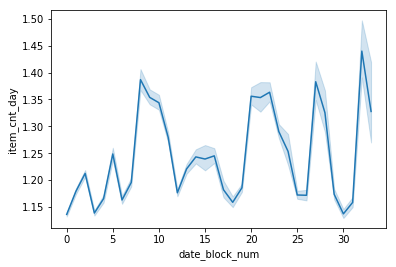

In [392]:
g1 = sns.lineplot(x="date_block_num", y="item_cnt_day", data = train)

In [328]:
train_df = train.groupby([train.date_block_num, train.item_id, train.shop_id]).sum().reset_index()

In [329]:
train_df.head()

,date_block_num,item_id,shop_id,item_price,item_cnt_day
0,0,19,25,28.0,1.0
1,0,27,1,1890.0,1.0
2,0,27,2,2499.0,1.0
3,0,27,10,1890.0,1.0
4,0,27,19,2499.0,1.0


In [393]:
train_df.describe()

,date_block_num,item_id,shop_id,item_price,item_cnt_day
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,1.068099e+04,3.280585e+01,1.625363e+03,2.267200e+00
std,9.542322e+00,6.238883e+03,1.653701e+01,5.701611e+03,8.649882e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01
25%,6.000000e+00,5.045000e+03,2.100000e+01,2.490000e+02,1.000000e+00
50%,1.400000e+01,1.049700e+04,3.100000e+01,4.990000e+02,1.000000e+00
75%,2.300000e+01,1.606000e+04,4.700000e+01,1.398000e+03,2.000000e+00
max,3.300000e+01,2.216900e+04,5.900000e+01,6.719300e+05,2.253000e+03


In [384]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## We are going to use LSTM for data prediction

## factor: item_cnt_day, item_price

In [330]:
count_df = train_df.drop(columns=['item_price'])

In [331]:
count_df.head()

,date_block_num,item_id,shop_id,item_cnt_day
0,0,19,25,1.0
1,0,27,1,1.0
2,0,27,2,1.0
3,0,27,10,1.0
4,0,27,19,1.0


In [332]:
count_df = count_df.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_cnt_day',fill_value=0)
count_df = count_df.reset_index()


In [333]:
count_df.head()

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [334]:
count_df = pd.merge(test,count_df, on=['item_id','shop_id'], how='left').fillna(0)

In [335]:
count_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
count_df = count_df.drop(labels=['ID','item_id','shop_id'],axis=1)

In [389]:
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
count_df.shape

(214200, 34)

In [338]:
#from sklearn.preprocessing import MinMaxScaler

In [339]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#train["item_price"] = scaler.fit_transform(train["item_price"].values.reshape(-1,1))
train_df2 = train.groupby([train.date_block_num, train.item_id, train.shop_id]).mean().reset_index()
train_df2 = train_df2[['date_block_num','item_id','shop_id','item_price']]
train_df2 = train_df2.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_price',fill_value=0).reset_index()


In [340]:
price_df = pd.merge(test,train_df2,on=['item_id','shop_id'], how='left').fillna(0)
price_df = price_df.drop(labels=['ID','item_id','shop_id'],axis=1)

In [391]:
price_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1999.0,0.0,0.0,0.0,1299.0,1499.0,1499.0,999.166667,749.5,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,899.0,599.0,0.0,599.000000,999.0,1199.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [341]:
price_df.shape

(214200, 34)

## Create train set

In [342]:
y_train = count_df[33]

In [343]:
y_train.shape

(214200,)

In [344]:
x_count = count_df.drop(labels=[33],axis=1)

In [345]:
x_count.shape

(214200, 33)

In [346]:
x_count = x_count.values.reshape((x_count.shape[0], x_count.shape[1], 1))

In [347]:
x_count.shape

(214200, 33, 1)

In [348]:
x_price = price_df.drop(labels=[33],axis=1)

In [349]:
x_price= x_price.values.reshape((x_price.shape[0], x_price.shape[1], 1))

In [350]:
x_price.shape

(214200, 33, 1)

In [351]:
X = np.append(x_count,x_price,axis=2)

In [352]:
# three dimensional with count and price
X.shape

(214200, 33, 2)

In [353]:
y = y_train.values.reshape((y_train.shape[0], 1))

In [354]:
y.shape

(214200, 1)

## Create test set

In [355]:
test_count_df = count_df.drop(labels=[0],axis=1)
x_count_test = test_count_df.values.reshape((test_count_df.shape[0], test_count_df.shape[1], 1))
test_price_df = price_df.drop(labels=[0],axis=1)
x_price_test = test_price_df.values.reshape((test_price_df.shape[0], test_price_df.shape[1], 1))

In [356]:
print(x_count_test.shape)
print(x_price_test.shape)

(214200, 33, 1)
(214200, 33, 1)


In [357]:
T = np.append(x_count_test, x_price_test, axis=2)

In [358]:
T.shape

(214200, 33, 2)

## Create model

In [359]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [360]:
m_lstm = Sequential()
m_lstm.add(LSTM(16, input_shape=(33, 2), return_sequences=True))
m_lstm.add(LSTM(32))
m_lstm.add(Dense(1))
m_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [361]:
m_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 33, 16)            1216      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


In [362]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=1, shuffle=False)

In [363]:
X_train.shape

(171360, 33, 2)

In [364]:
X_val.shape

(42840, 33, 2)

In [365]:
y_train.shape

(171360, 1)

In [366]:
y_val.shape

(42840, 1)

In [371]:
hist = m_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=12, epochs = 10)

Train on 171360 samples, validate on 42840 samples
Epoch 1/10
171360/171360 [==============================] - 605s 4ms/step - loss: 37.0610 - mean_squared_error: 37.0610 - val_loss: 0.9960 - val_mean_squared_error: 0.9960
Epoch 2/10
171360/171360 [==============================] - 594s 3ms/step - loss: 36.2260 - mean_squared_error: 36.2260 - val_loss: 0.8945 - val_mean_squared_error: 0.8945
Epoch 3/10
171360/171360 [==============================] - 596s 3ms/step - loss: 35.9007 - mean_squared_error: 35.9007 - val_loss: 0.8997 - val_mean_squared_error: 0.8997
Epoch 4/10
171360/171360 [==============================] - 572s 3ms/step - loss: 35.5079 - mean_squared_error: 35.5079 - val_loss: 0.8468 - val_mean_squared_error: 0.8468
Epoch 5/10
171360/171360 [==============================] - 571s 3ms/step - loss: 35.0649 - mean_squared_error: 35.0649 - val_loss: 0.8383 - val_mean_squared_error: 0.8383
Epoch 6/10
171360/171360 [==============================] - 573s 3ms/step - loss: 35.3646

In [379]:
y_preict = m_lstm.predict(X)

In [380]:
from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [382]:
rmse = sqrt(mean_squared_error(y,y_preict))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 5.227


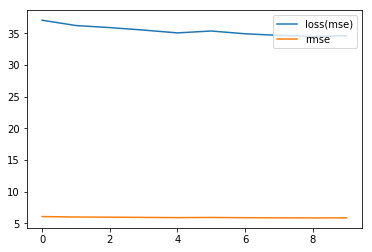

In [388]:
plt.plot(hist.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(hist.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

In [383]:
sub = pd.DataFrame(y_preict,columns=['item_cnt_month'])
sub.to_csv('submission.csv',index_label='ID')